### Running XY and Rydberg interaction

In [33]:
import math
import matplotlib.pyplot as plt
from emu_mps import (
    MPS,
    MPSConfig, 
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation,
    StateResult
)

import pulser
from pulser.devices import MockDevice

from typing import Any

import numpy as np
import torch

In [34]:
def afm_sequence_from_register(
    reg: pulser.Register,
    Omega_max: float,
    delta_0: float,
    delta_f: float,
    t_rise: int,
    t_fall: int,
    factor_sweep: int,
    device: Any = pulser.devices.MockDevice,
) -> pulser.Sequence:
    """Sequence that creates AntiFerromagnetic State (AFM) for 1d chain of atoms using pulser.
    This function constructs a sequence of pulses to transition a system of qubits
    distributed in a 1d chain (represented by `reg`) into an AFM state using a specified device.
    The sequence consists of three phases: a rise, a sweep, and a fall.
    For more information, check Pulser
    [tutorial](https://pulser.readthedocs.io/en/stable/tutorials/afm_prep.html)."""

    t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000 * factor_sweep
    rise = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep = pulser.Pulse.ConstantAmplitude(
        Omega_max, pulser.waveforms.RampWaveform(int(t_sweep), delta_0, delta_f), 0.0
    )
    fall = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
    )

    seq = pulser.Sequence(reg, device)
    seq.declare_channel("ising_global", "rydberg_global")
    seq.add(rise, "ising_global")
    seq.add(sweep, "ising_global")
    seq.add(fall, "ising_global")

    return seq


def square_perimeter_points(L: int) -> np.ndarray:
    """
    Calculate the coordinates of the points located on the perimeter of a square of size L.
    The square is centered at the origin (0, 0) with sides parallel to the axes.
    The points are ordered starting from the bottom-left corner and moving
    counter-clockwise around the square. The order is important when measuare the bitstrings

    Args:
        L (int): The length of the side of the square. L should be a positive integer.

    Returns:
        np.ndarray: An array of shape (4*L-4, 2) containing the coordinates of the perimeter points.

    Example:
        >>> square_perimeter_points(3)
        array([[-1, -1],
               [-1,  0],
               [-1,  1],
               [ 0,  1],
               [ 1,  1],
               [ 1,  0],
               [ 1, -1],
               [ 0, -1]])
    """
    pairOrodd = L % 2
    toGrid = int(math.floor(L / 2))
    if pairOrodd == 0:
        axis = list(range(-toGrid, toGrid, 1))
    else:
        axis = list(range(-toGrid, toGrid + 1, 1))
    coord = []
    for i in axis:  # from left, first column of the perimeter
        coord.append([axis[0], i])

    for i in axis[1:-1]:
        coord.append([i, axis[-1]])

    for i in reversed(axis):
        coord.append([axis[-1], i])

    for i in reversed(axis[1:-1]):
        coord.append([i, axis[0]])

    return np.array(coord)

In [35]:
Omega_max = 2 * 2 * np.pi
delta_0 = -6 * Omega_max / 2
delta_f = 1 * Omega_max / 2
t_rise = 500
t_fall = 1500
sweep_factor = 2

square_length = 2
R_interatomic = MockDevice.rydberg_blockade_radius(Omega_max / 2)

/home/mauro/Documents/pasqal/code/.venv/lib/python3.10/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)


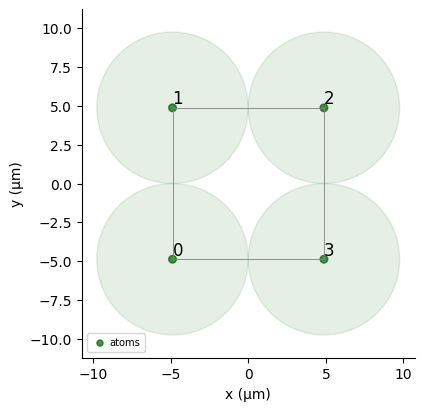

In [36]:
coords = R_interatomic * square_perimeter_points(square_length)
reg = pulser.Register.from_coordinates(coords)
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

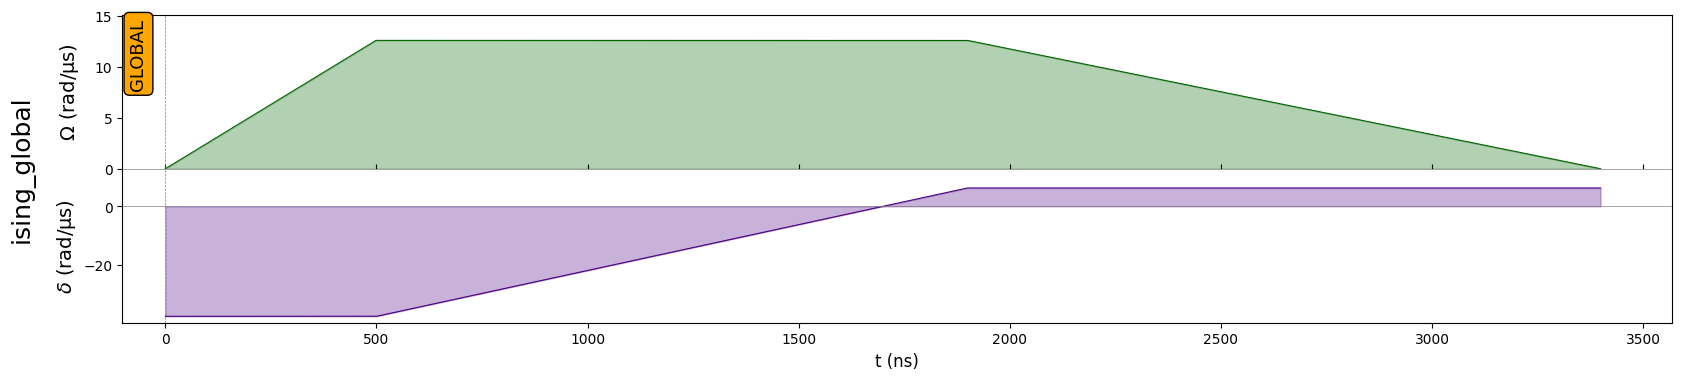

In [37]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, MockDevice
)
seq.draw("input")

In [38]:
### sequence with xy model that uses the previous register in order to get the interaction xy matrix
from math import pi
from pulser._hamiltonian_data import HamiltonianData
const_pulse = pulser.Pulse.ConstantAmplitude(
    2*pi, pulser.waveforms.RampWaveform(200, 0.0, pi), 0.0
)
seq_xy = pulser.Sequence(reg, MockDevice) # MockDevice has xy and ryderberg
seq_xy.declare_channel("mw_global", "mw_global")
seq_xy.add(const_pulse, "mw_global")

xy_ham_data = HamiltonianData.from_sequence(seq_xy)

interaction_matrix_xy = xy_ham_data._interaction_matrix

In [39]:
dt = 10
eval_times = [1.0]

basis = ("r","g","x") # leakage state |x> as |r1>, in the xy model  

In [40]:
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)

In [41]:
nqubits = len(seq.register.qubit_ids)

afm_string_pure = {"rg"*int((square_length**2-(square_length-2)**2)/2): 1.0} # |10101010> in ground-rydberg basis

afm_mps_state = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=afm_string_pure
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times, state=afm_mps_state)
density = Occupation(
    evaluation_times=[x/seq.get_duration() for x in range(0, seq.get_duration(), dt)]
)
state = StateResult(evaluation_times=eval_times)

In [42]:
afm_mps_state.factors[0]

tensor([[[0.+0.j],
         [1.+0.j],
         [0.+0.j]]], device='cuda:0', dtype=torch.complex128)

In [43]:
## adding a random interaction matrix for the xy
# rows = 2*square_length+2*(square_length-2)
# interaction_matrix_xy = torch.rand(rows,rows)
# interaction_matrix_xy = (interaction_matrix_xy + interaction_matrix_xy.T)/2
# interaction_matrix_xy.fill_diagonal_(0.0)
# interaction_matrix_xy.shape

In [ ]:
# lindbladians are using the leakage state |x> as |r1>.
# the basis will be |g>, |r>, |x>=|r1>

dtype = torch.complex128
l1 = torch.zeros(3, 3, dtype=dtype)
l1[1, 2] = 1.0  # l1 = |r><x| = |r><r1| for xy model 
l2 = l1.mT  # l2 = |x><r|= |r1><r| for xy model
lindbladians = [l1, l2]

noise_model = pulser.NoiseModel(
    eff_noise_opers=lindbladians,
    eff_noise_rates=(0.01, 0.01),  # decay from |r> to |r1> and from |r1> to |r>
    with_leakage=True,  # the leakage will be the |r1> for the xy model (|r> is |0>, |r1> is |1>)
)

In [45]:
mpsconfig = MPSConfig(
    dt=dt,
    #precision=1.0e-9,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
        state
    ],
    interaction_matrix_xy= interaction_matrix_xy,
    log_level=10,
    noise_model=noise_model
)

emu-mps allows only {'energy_second_moment', 'correlation_matrix', 'energy_variance', 'statistics', 'energy', 'bitstrings', 'occupation'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'state', 'fidelity'} using `optimize_qubit_ordering = False` instead.


In [46]:
sim = MPSBackend(seq, config=mpsconfig)

results = []
nruns = 50
for _ in range(nruns):
    results.append(sim.run())

emu-mps allows only {'energy_second_moment', 'correlation_matrix', 'energy_variance', 'statistics', 'energy', 'bitstrings', 'occupation'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'state', 'fidelity'} using `optimize_qubit_ordering = False` instead.
Will save simulation state to file "emu_mps_save_6849e8e0-efb6-11f0-b218-c70ca0e5a487.dat"
            every inf seconds.
To resume: `MPSBackend().resume("/home/mauro/Documents/pasqal/code/emulators/docs/emu_mps/notebooks/emu_mps_save_6849e8e0-efb6-11f0-b218-c70ca0e5a487.dat")`
step = 1/340, χ = 1, |ψ| = 0.000 MB, RSS = 21.131 MB, Δt = 0.045 s
step = 2/340, χ = 1, |ψ| = 0.000 MB, RSS = 21.131 MB, Δt = 0.019 s
step = 3/340, χ = 1, |ψ| = 0.000 MB, RSS = 21.131 MB, Δt = 0.015 s
step = 4/340, χ = 1, |ψ| = 0.000 MB, RSS = 21.131 MB, Δt = 0.016 s
step = 5/340, χ = 1, |ψ| = 0.000 MB, RSS = 21.131 MB, Δt = 0.017 s
step = 6/340, χ = 2, |ψ| = 0.001 MB, RSS = 21.131 MB, Δt = 0.019 s
step = 7/340, χ = 3, |ψ| = 0.001 M

In [47]:
aggregated_results = pulser.backend.Results.aggregate(results)

/home/mauro/Documents/pasqal/code/.venv/lib/python3.10/site-packages/pulser/backend/results.py:367: UserWarning: Skipping aggregation of `state`.
  warnings.warn(f"Skipping aggregation of `{tag}`.")


In [48]:
aggregated_results.get_result_times(density.tag)

[0.0,
 0.0029411764705882353,
 0.0058823529411764705,
 0.008823529411764706,
 0.011764705882352941,
 0.014705882352941176,
 0.01764705882352941,
 0.020588235294117647,
 0.023529411764705882,
 0.026470588235294117,
 0.029411764705882353,
 0.03235294117647059,
 0.03529411764705882,
 0.03823529411764706,
 0.041176470588235294,
 0.04411764705882353,
 0.047058823529411764,
 0.05,
 0.052941176470588235,
 0.05588235294117647,
 0.058823529411764705,
 0.061764705882352944,
 0.06470588235294118,
 0.06764705882352941,
 0.07058823529411765,
 0.07352941176470588,
 0.07647058823529412,
 0.07941176470588235,
 0.08235294117647059,
 0.08529411764705883,
 0.08823529411764706,
 0.09117647058823529,
 0.09411764705882353,
 0.09705882352941177,
 0.1,
 0.10294117647058823,
 0.10588235294117647,
 0.10882352941176471,
 0.11176470588235295,
 0.11470588235294117,
 0.11764705882352941,
 0.12058823529411765,
 0.12352941176470589,
 0.1264705882352941,
 0.12941176470588237,
 0.1323529411764706,
 0.13529411764705881,

In [49]:
aggregated_results.get_result(density.tag, 1.0)[0] # average magnetization of qubit 0 at time 100ns

tensor(0.5163, dtype=torch.float64)

In [50]:
aggregated_results.get_result(bitstrings.tag, 1.0)

Counter({'0101': 16834,
         '1010': 16377,
         '1100': 1728,
         '1001': 1660,
         '0110': 1613,
         '0011': 1602,
         '1000': 1542,
         '0111': 1445,
         '1101': 1444,
         '1110': 1407,
         '1011': 1377,
         '0001': 987,
         '0100': 936,
         '0010': 888,
         '1111': 101,
         '0000': 59})

The most frequent bitstring is ['0101'] which was sampled 16834 times


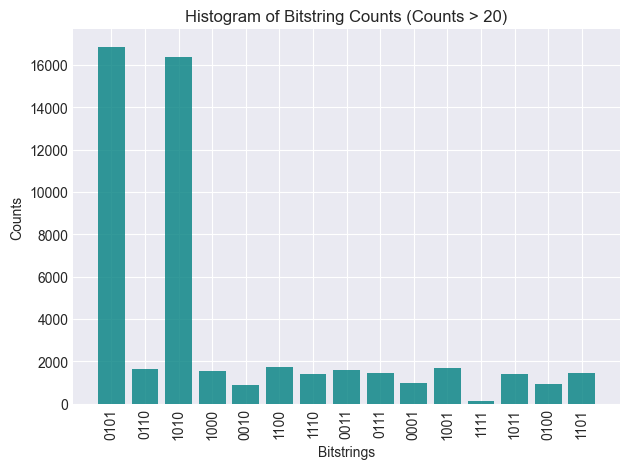

In [51]:
aggregated_results.get_result_times(bitstrings.tag)
bitstrings_final = aggregated_results.get_result(bitstrings.tag, 1.0)

max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 100]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 100
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

In [52]:
aggregated_results.get_result_tags()

['bitstrings', 'occupation', 'fidelity']

In [53]:
fidelity_pure = aggregated_results.get_result(density.tag, 1.0)

print(
    "The probability of the system being in the sate |rgrgrgr> is equal to {} ".format(
        fidelity_pure,
    )
)

#"rg"*int((square_length**2-(square_length-2)**2)/2)

The probability of the system being in the sate |rgrgrgr> is equal to tensor([0.5163, 0.5052, 0.5010, 0.5052], dtype=torch.float64) 


In [54]:
magnetization_values = np.array(list(aggregated_results.occupation))
magnetization_times = aggregated_results.get_result_times(density.tag) 

In [55]:
# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())

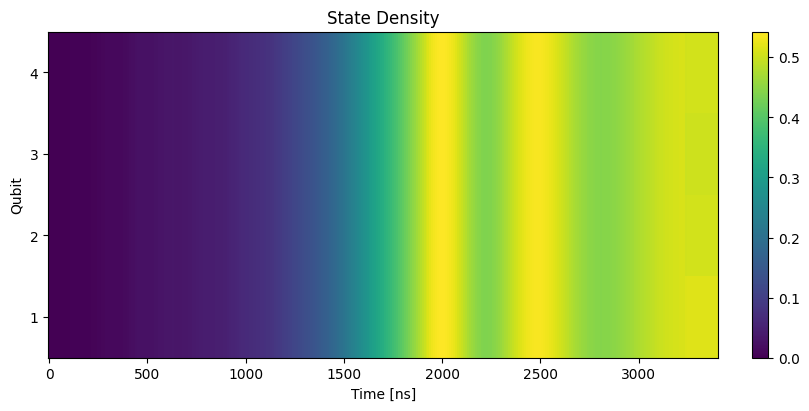

In [56]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)